# EuroSAT Baseline Classic Models

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import time

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

%matplotlib inline

## Load dataset

In [2]:
def load_eurosat_dataset(data_dir="data"):
    data_path = Path(data_dir)

    # Get all class directories
    class_dirs = [d for d in data_path.iterdir() if d.is_dir()]
    class_names = sorted([d.name for d in class_dirs])

    print(f"Found {len(class_names)} classes: {class_names}")

    images = []
    labels = []

    # Load images from each class
    for class_idx, class_name in enumerate(class_names):
        class_path = data_path / class_name
        image_files = list(class_path.glob("*.jpg")) + list(class_path.glob("*.png"))

        print(f"Loading {len(image_files)} images from {class_name}...")

        for img_path in image_files:
            try:
                # Load image
                img = Image.open(img_path)
                img_array = np.array(img)

                # Store image and label
                images.append(img_array)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    # Convert to numpy arrays
    data = np.array(images)
    labels = np.array(labels)

    print(f"\nDataset loaded successfully!")
    print(f"Total images           : {len(data)}")
    print(f"Data shape             : {data.shape}")
    print(f"Labels shape           : {labels.shape}")

    return data, labels, class_names


# Load the dataset
data, labels, class_names = load_eurosat_dataset("data")

Found 10 classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Loading 3000 images from AnnualCrop...
Loading 3000 images from Forest...
Loading 3000 images from HerbaceousVegetation...
Loading 2500 images from Highway...
Loading 2500 images from Industrial...
Loading 2000 images from Pasture...
Loading 2500 images from PermanentCrop...
Loading 3000 images from Residential...
Loading 2500 images from River...
Loading 3000 images from SeaLake...

Dataset loaded successfully!
Total images           : 27000
Data shape             : (27000, 64, 64, 3)
Labels shape           : (27000,)


## Feature extraction

In [3]:
def extract_features(image):
    features = []

    # RGB channel statistics (6 features)
    for channel in range(3):
        features.append(image[..., channel].mean())  # Mean for R, G, B
        features.append(image[..., channel].std())  # Std for R, G, B

    # Brightness statistics (2 features)
    brightness = 0.299 * image[..., 0] + 0.587 * image[..., 1] + 0.114 * image[..., 2]
    features.append(brightness.mean())
    features.append(brightness.std())

    # Contrast (1 feature)
    contrast = image.std()
    features.append(contrast)

    # Pixel value statistics (3 features)
    features.append(image.min())
    features.append(image.max())
    features.append(np.median(image))

    return np.array(features)


# Extract features from all images
print("Extracting features from images...")
start_time = time.time()

X = np.array([extract_features(img) for img in data])
y = labels

end_time = time.time()
print(
    f"Feature extraction completed in             : {end_time - start_time:.2f} seconds"
)
print(f"Feature matrix shape                        : {X.shape}")
print(f"Number of features per image                : {X.shape[1]}")

Extracting features from images...
Feature extraction completed in             : 5.49 seconds
Feature matrix shape                        : (27000, 12)
Number of features per image                : 12


In [4]:
# Display feature statistics
feature_names = [
    "R_mean",
    "R_std",
    "G_mean",
    "G_std",
    "B_mean",
    "B_std",
    "brightness_mean",
    "brightness_std",
    "contrast",
    "pixel_min",
    "pixel_max",
    "pixel_median",
]

feature_df = pd.DataFrame(X, columns=feature_names)
print("\nFeature:")
print(feature_df.head(5))


Feature:
       R_mean      R_std      G_mean      G_std      B_mean      B_std  \
0  119.488525  42.637695  121.351807  19.385658  119.371338  18.565473   
1  115.563721  44.279462  113.476807  25.915916  110.764893  22.730603   
2  172.473633  64.115883  136.837646  32.941343  126.442627  22.481973   
3  169.530762  43.727902  147.759766  31.589846  138.062256  26.238712   
4  172.199707  33.379157  135.745605  20.519028  127.583740  16.045508   

   brightness_mean  brightness_std   contrast  pixel_min  pixel_max  \
0       120.568912       25.804793  29.102822       57.0      207.0   
1       113.791636       30.832019  32.458000       47.0      253.0   
2       146.307774       40.790572  47.843595       68.0      255.0   
3       153.163777       34.200837  37.049274       55.0      255.0   
4       145.714929       23.740373  31.205542       55.0      240.0   

   pixel_median  
0         116.0  
1         108.0  
2         134.0  
3         147.0  
4         140.0  


In [5]:
print("\nFeature statistics:")
print(feature_df.describe())


Feature statistics:
             R_mean         R_std        G_mean         G_std        B_mean  \
count  27000.000000  27000.000000  27000.000000  27000.000000  27000.000000   
mean      87.815869     23.298769     96.974164     16.605197    103.981423   
std       43.054911     16.558618     28.209471     12.130154     23.308523   
min       22.274902      0.464302     37.954346      0.607290     57.098389   
25%       53.535400      9.681271     78.382263      7.237105     85.386658   
50%       80.520386     21.203575     93.425049     14.287696    101.277466   
75%      114.159912     34.364487    114.023682     23.464101    119.243469   
max      253.770996     91.094017    209.332031     71.311797    204.489990   

              B_std  brightness_mean  brightness_std      contrast  \
count  27000.000000     27000.000000    27000.000000  27000.000000   
mean      14.086304        95.034662       18.043215     24.068469   
std       11.247949        31.601141       13.092670     

## Data split and feature scaling

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.13, random_state=42, stratify=y_train
)

print(f"Training set size:          {X_train.shape[0]} samples")
print(f"Validation set size:        {X_val.shape[0]} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("\nFeature scaling completed")

Training set size:          18792 samples
Validation set size:        2808 samples

Feature scaling completed


## Model training and evaluation

In [9]:
def evaluate_model_with_gridsearch(
    model, param_grid, X_train, X_val, y_train, y_val, model_name
):
    """Train model with GridSearchCV and evaluate on validation set"""

    print(f"Training {model_name} with GridSearchCV...")
    print(f"Parameter grid: {param_grid}")

    # GridSearchCV with 5-fold cross-validation
    start_time = time.time()
    grid_search = GridSearchCV(
        model, param_grid, cv=5, scoring="f1_weighted", n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Get best model
    best_model = grid_search.best_estimator_

    print(f"\nBest parameters                     : {grid_search.best_params_}")
    print(f"Best cross-validation score         : {grid_search.best_score_:.4f}")
    print(f"Training time                       : {train_time:.2f} seconds")

    # Predict on validation set
    start_time = time.time()
    y_pred = best_model.predict(X_val)
    predict_time = time.time() - start_time

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average="weighted")
    recall = recall_score(y_val, y_pred, average="weighted")
    f1 = f1_score(y_val, y_pred, average="weighted")

    # Print results
    print(f"Prediction time: {predict_time:.2f} seconds")
    print(f"\nValidation Set Performance Metrics:")
    print(f"  Accuracy              : {accuracy:.4f}")
    print(f"  Precision             : {precision:.4f}")
    print(f"  Recall                : {recall:.4f}")
    print(f"  F1-Score              : {f1:.4f}")

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=class_names))

    return {
        "model": best_model,
        "grid_search": grid_search,
        "model_name": model_name,
        "y_pred": y_pred,
        "best_params": grid_search.best_params_,
        "cv_score": grid_search.best_score_,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "train_time": train_time,
        "predict_time": predict_time,
    }

### 1. K-Nearest Neighbors (KNN)

In [10]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn_param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}

knn_results = evaluate_model_with_gridsearch(
    knn, knn_param_grid, X_train_scaled, X_val_scaled, y_train, y_val, "KNN"
)

Training KNN with GridSearchCV...
Parameter grid: {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters                     : {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best cross-validation score         : 0.7553
Training time                       : 3.41 seconds
Prediction time: 0.09 seconds

Validation Set Performance Metrics:
  Accuracy              : 0.7646
  Precision             : 0.7631
  Recall                : 0.7646
  F1-Score              : 0.7612

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.82      0.77      0.80       312
              Forest       0.92      0.97      0.95       312
HerbaceousVegetation       0.76      0.72      0.74       312
             Highway       0.48      0.40      0.43       260
          Industrial       0.82      0.91     

### 2. Support Vector Classifier (SVC)

In [11]:
# Support Vector Classifier
svc = SVC(random_state=42)
svc_param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["rbf"],
    "gamma": ["scale", "auto"],
}

svc_results = evaluate_model_with_gridsearch(
    svc, svc_param_grid, X_train_scaled, X_val_scaled, y_train, y_val, "SVC"
)

Training SVC with GridSearchCV...
Parameter grid: {'C': [0.1, 1, 10, 100], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters                     : {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score         : 0.8277
Training time                       : 21.26 seconds
Prediction time: 1.13 seconds

Validation Set Performance Metrics:
  Accuracy              : 0.8405
  Precision             : 0.8384
  Recall                : 0.8405
  F1-Score              : 0.8387

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.85      0.87      0.86       312
              Forest       0.93      0.96      0.94       312
HerbaceousVegetation       0.82      0.89      0.86       312
             Highway       0.63      0.53      0.58       260
          Industrial       0.89      0.91      0.90       260
             Pasture       0.85      0.88

### 3. Random Forest

In [12]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rf_results = evaluate_model_with_gridsearch(
    rf, rf_param_grid, X_train_scaled, X_val_scaled, y_train, y_val, "Random Forest"
)

Training Random Forest with GridSearchCV...
Parameter grid: {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters                     : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score         : 0.7818
Training time                       : 276.81 seconds
Prediction time: 0.09 seconds

Validation Set Performance Metrics:
  Accuracy              : 0.7831
  Precision             : 0.7795
  Recall                : 0.7831
  F1-Score              : 0.7801

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.79      0.83      0.81       312
              Forest       0.94      0.96      0.95       312
HerbaceousVegetation       0.75      0.72      0.74       312
             Highway       0.52      0.43      0.47 

## Model comparison

In [13]:
# Compare all models
results_summary = pd.DataFrame(
    {
        "Model": [
            knn_results["model_name"],
            svc_results["model_name"],
            rf_results["model_name"],
        ],
        "Best Params": [
            str(knn_results["best_params"]),
            str(svc_results["best_params"]),
            str(rf_results["best_params"]),
        ],
        "CV Score": [
            knn_results["cv_score"],
            svc_results["cv_score"],
            rf_results["cv_score"],
        ],
        "Val Accuracy": [
            knn_results["accuracy"],
            svc_results["accuracy"],
            rf_results["accuracy"],
        ],
        "Precision": [
            knn_results["precision"],
            svc_results["precision"],
            rf_results["precision"],
        ],
        "Recall": [knn_results["recall"], svc_results["recall"], rf_results["recall"]],
        "F1-Score": [knn_results["f1"], svc_results["f1"], rf_results["f1"]],
        "Train Time (s)": [
            knn_results["train_time"],
            svc_results["train_time"],
            rf_results["train_time"],
        ],
    }
)

print(results_summary.to_string(index=False))

        Model                                                                           Best Params  CV Score  Val Accuracy  Precision   Recall  F1-Score  Train Time (s)
          KNN                      {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}  0.755263      0.764601   0.763085 0.764601  0.761174        3.406631
          SVC                                          {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}  0.827677      0.840456   0.838376 0.840456  0.838708       21.264939
Random Forest {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}  0.781769      0.783120   0.779526 0.783120  0.780136      276.812209


## Confusion matrices

In [15]:
def plot_confusion_matrix(y_val, y_pred, class_names, model_name):
    """Plot confusion matrix as heatmap"""
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={"label": "Number of samples"},
    )
    plt.xlabel("Predicted Label", fontsize=12, fontweight="bold")
    plt.ylabel("True Label", fontsize=12, fontweight="bold")
    plt.title(f"Confusion Matrix - {model_name}", fontsize=14, fontweight="bold")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm

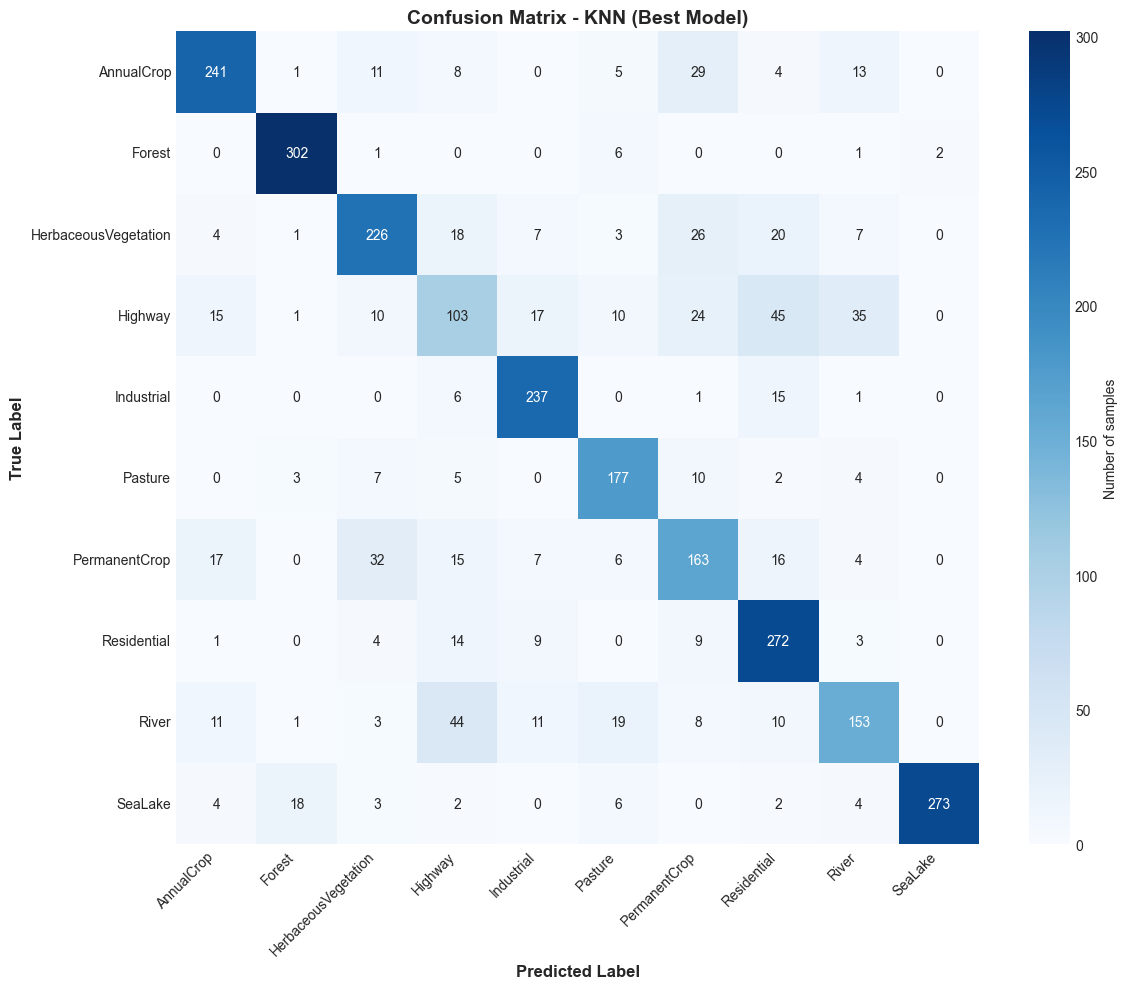

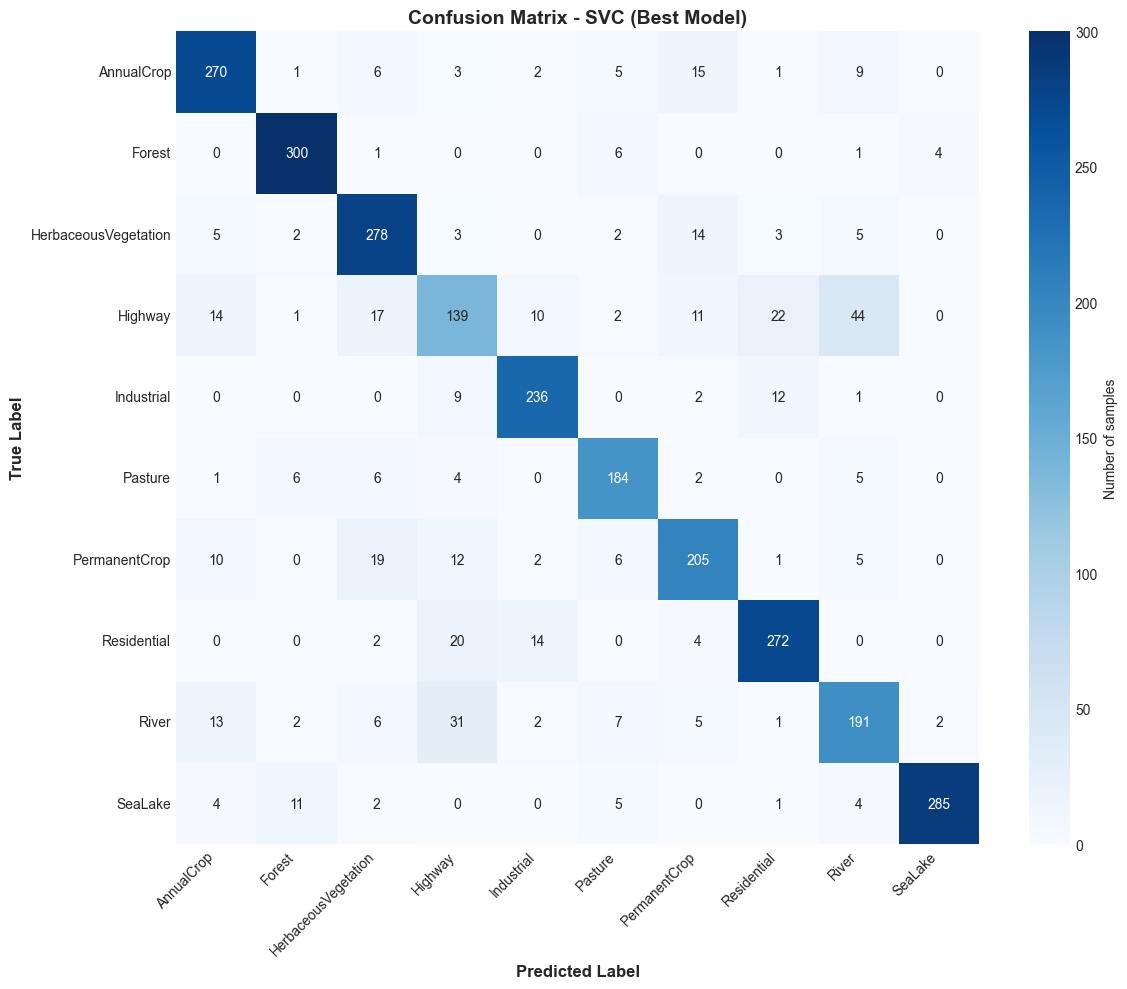

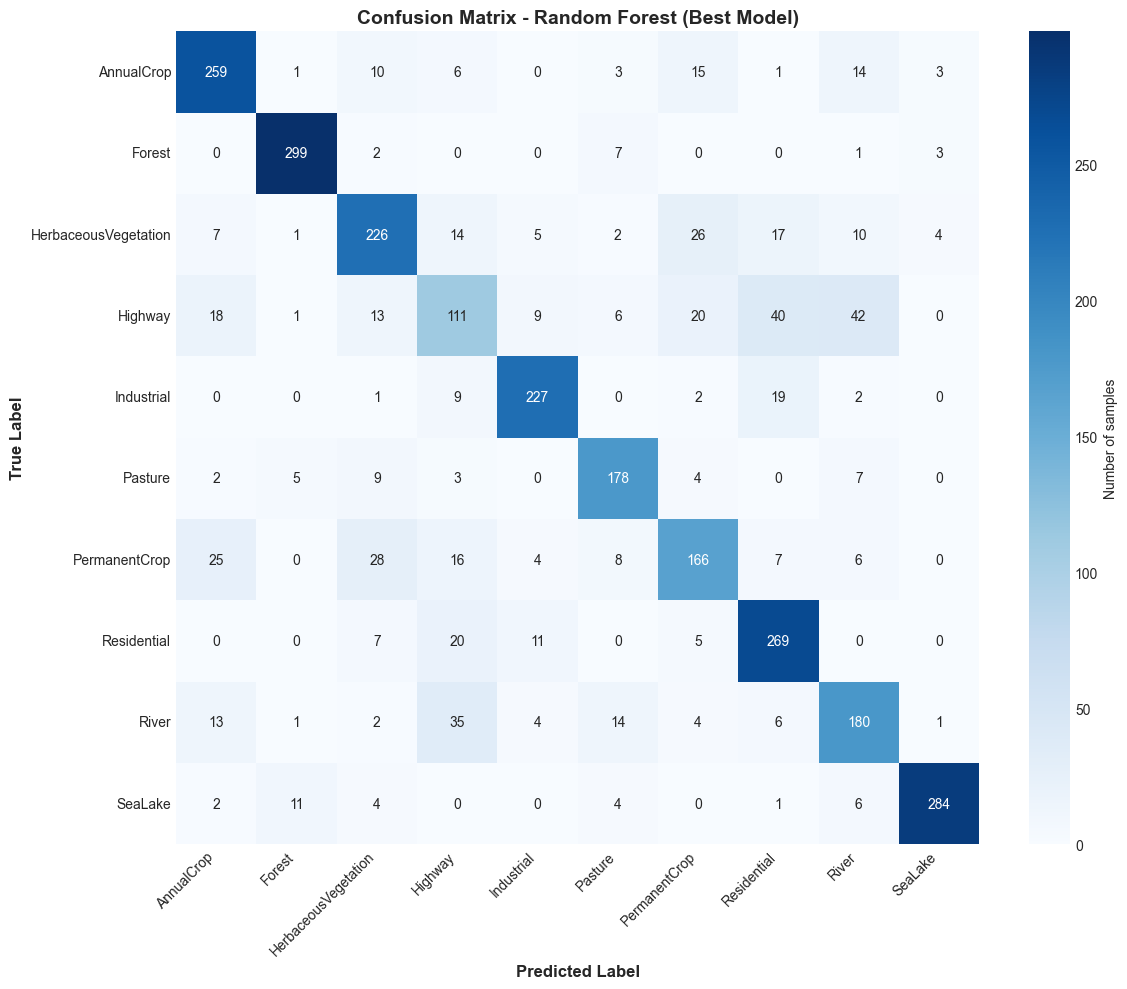

In [16]:
# Confusion matrices for all best models
cm_knn = plot_confusion_matrix(
    y_val, knn_results["y_pred"], class_names, "KNN (Best Model)"
)
cm_svc = plot_confusion_matrix(
    y_val, svc_results["y_pred"], class_names, "SVC (Best Model)"
)
cm_rf = plot_confusion_matrix(
    y_val, rf_results["y_pred"], class_names, "Random Forest (Best Model)"
)